<a href="https://colab.research.google.com/github/raghu-sanikommu/mm-rag/blob/main/mmRAG_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multimodal RAG 🔍

Dev Info:
- Embedding Dimension of gemini model: 768

## Phase 1:

- Upload PDF
- Extract text & images from PDF using `unstructured`
- Split the text chunks based on token limit
- Generate text embeddings for texts splitted
- Generate image summary within token limit using LLM by passing image to Vision LLM `gemini`
- Generate text embeddings for summary generated

In [ ]:
!pip install --upgrade unstructured

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.7/274.7 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━

In [ ]:
!apt-get -qq install poppler-utils tesseract-ocr
%pip install -q --user --upgrade pillow

!pip install --quiet -U langchain-text-splitters tiktoken

!pip install --quiet -U google-generativeai

Selecting previously unselected package poppler-utils.
(Reading database ... 123597 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.5_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.5) ...
Selecting previously unselected package tesseract-ocr-eng.
Preparing to unpack .../tesseract-ocr-eng_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-eng (1:4.00~git30-7274cfa-1.1) ...
Selecting previously unselected package tesseract-ocr-osd.
Preparing to unpack .../tesseract-ocr-osd_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-osd (1:4.00~git30-7274cfa-1.1) ...
Selecting previously unselected package tesseract-ocr.
Preparing to unpack .../tesseract-ocr_4.1.1-2.1build1_amd64.deb ...
Unpacking tesseract-ocr (4.1.1-2.1build1) ...
Setting up tesseract-ocr-eng (1:4.00~git30-7274cfa-1.1) ...
Setting up tesseract-ocr-osd (1:4.00~git30-7274cfa-1.1) ...
Setting up poppler-utils (22.02.0-2ubuntu0.5) ...
Setting up tess

In [ ]:
!pip install --upgrade nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.3 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nltk-3.8.1


In [ ]:
# Install NLTK Data
import nltk
nltk.download('punkt_tab')  # Download the correct punkt_tab resource
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
!mkdir -p pdfs
!mkdir -p images

In [ ]:
!pip install pi_heif
!pip install unstructured[local-inference]
from unstructured.partition.pdf import partition_pdf
import os
from langchain_text_splitters import RecursiveCharacterTextSplitter
import base64
from google.colab import userdata
import google.generativeai as genai
import PIL.Image

In [ ]:
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

text_embedding_model = "models/text-embedding-004"
text_embedding_model_for_text_splitting = "text-embedding-3-small"  # since encoding of models/text-embedding-004 isn't available yet
llm_model = 'gemini-1.5-flash'
images_folder_path = '/content/images'
pdfs_folder_path = '/content/pdfs'
extracted_pdfs = []
texts_to_embed = []
images_to_embed = []

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    model_name=text_embedding_model_for_text_splitting,
    chunk_size=100,
    chunk_overlap=0,
)

genai.configure(api_key=GOOGLE_API_KEY)
gemini_model = genai.GenerativeModel(llm_model)


In [ ]:
for pdf_file in sorted(os.listdir(pdfs_folder_path)):
    pdf_path = os.path.join(pdfs_folder_path, pdf_file)
    print("Extracting content from PDF - " + pdf_path)
    try:
        extracted_pdfs.append({
            "chunks": partition_pdf(pdf_path,
                extract_images_in_pdf=True,
                extract_image_block_output_dir=os.path.join(images_folder_path, pdf_file)),
            "filename": pdf_file
          }
        )
    except PIL.UnidentifiedImageError as e:
        print(f"Error processing {pdf_file}: {e}")

print(f"Total PDFs processed: {len(extracted_pdfs)}")
print(f"Chunks per PDF: {[len(extracted_pdfs[i]['chunks']) for i in range(len(extracted_pdfs))]}")


Extracting content from PDF - /content/pdfs/Animal Cell Culture and Technology-25-36.pdf


yolox_l0.05.onnx:   0%|          | 0.00/217M [00:00<?, ?B/s]

Extracting content from PDF - /content/pdfs/gym_supps.pdf
Total PDFs processed: 2
Chunks per PDF: [114, 41]


In [ ]:
[len(extracted_pdfs[i]['chunks']) for i in range(len(extracted_pdfs))]

[114, 41]

In [ ]:
for extracted_pdf in extracted_pdfs:
    total_chunks = len(extracted_pdf.get('chunks'))

    for index, chunk in enumerate(extracted_pdf.get('chunks')):
        print(f'Processing chunk {index+1}/{total_chunks} of {extracted_pdf.get("filename")}')

        if chunk.category != "Image":
            splitted_text = text_splitter.split_text(chunk.text)
            print(f"Splitting text into {len(splitted_text)} chunks")
            for text in splitted_text:
                embedding_response = genai.embed_content(model=text_embedding_model, content=text)
                embedding = embedding_response.get('embedding')
                if embedding is None:
                    print(f"No embedding returned for text: {text[:100]}")  # Print first 100 characters for debugging
                else:
                    texts_to_embed.append({
                        "type": "text",
                        "filename": extracted_pdf.get('filename'),
                        "text": text,
                        "embedding": embedding
                    })
            print(f"Total text embeddings added: {len(texts_to_embed)}")


Processing chunk 1/114 of Animal Cell Culture and Technology-25-36.pdf
Splitting text into 1 chunks
Total text embeddings added: 1
Processing chunk 2/114 of Animal Cell Culture and Technology-25-36.pdf
Splitting text into 1 chunks
Total text embeddings added: 2
Processing chunk 3/114 of Animal Cell Culture and Technology-25-36.pdf
Splitting text into 2 chunks
Total text embeddings added: 4
Processing chunk 4/114 of Animal Cell Culture and Technology-25-36.pdf
Splitting text into 1 chunks
Total text embeddings added: 5
Processing chunk 5/114 of Animal Cell Culture and Technology-25-36.pdf
Splitting text into 1 chunks
Total text embeddings added: 6
Processing chunk 6/114 of Animal Cell Culture and Technology-25-36.pdf
Splitting text into 2 chunks
Total text embeddings added: 8
Processing chunk 7/114 of Animal Cell Culture and Technology-25-36.pdf
Splitting text into 1 chunks
Total text embeddings added: 9
Processing chunk 8/114 of Animal Cell Culture and Technology-25-36.pdf
Splitting te

In [ ]:
# texts_to_embed
print(len(texts_to_embed))


161


In [ ]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

for folder in sorted(os.listdir(images_folder_path)):
    file_imgs_folder = os.path.join(images_folder_path, folder)
    print(f"Processing images in folder: {file_imgs_folder}")

    for img_file in sorted(os.listdir(file_imgs_folder)):
        encoded_image = encode_image(os.path.join(file_imgs_folder, img_file))

        print("Summarizing & embedding image - " + os.path.join(file_imgs_folder, img_file))
        raw_img = PIL.Image.open(os.path.join(file_imgs_folder, img_file))
        gemini_res = gemini_model.generate_content(["Give a brief description of attached image to store it in Vector Database for RAG Search within 100 tokens. Also specify its an image so that RAG can understand its an image description", raw_img])
        if gemini_res.text is None:
            print(f"No description generated for image: {img_file}")
        else:
            embedding_response = genai.embed_content(model=text_embedding_model, content=gemini_res.text)
            embedding = embedding_response.get('embedding')
            if embedding is None:
                print(f"No embedding returned for image description: {gemini_res.text[:100]}")
            else:
                images_to_embed.append({
                    "type": "image",
                    "base64_image": encoded_image,
                    "filename": folder,
                    "text": gemini_res.text,
                    "embedding": embedding
                })
        print(f"Total image embeddings added: {len(images_to_embed)}")


Processing images in folder: /content/images/Animal Cell Culture and Technology-25-36.pdf
Summarizing & embedding image - /content/images/Animal Cell Culture and Technology-25-36.pdf/figure-10-7.jpg
Total image embeddings added: 1
Summarizing & embedding image - /content/images/Animal Cell Culture and Technology-25-36.pdf/figure-2-1.jpg
Total image embeddings added: 2
Summarizing & embedding image - /content/images/Animal Cell Culture and Technology-25-36.pdf/figure-4-2.jpg
Total image embeddings added: 3
Summarizing & embedding image - /content/images/Animal Cell Culture and Technology-25-36.pdf/figure-5-3.jpg
Total image embeddings added: 4
Summarizing & embedding image - /content/images/Animal Cell Culture and Technology-25-36.pdf/figure-6-4.jpg
Total image embeddings added: 5
Summarizing & embedding image - /content/images/Animal Cell Culture and Technology-25-36.pdf/figure-7-5.jpg
Total image embeddings added: 6
Summarizing & embedding image - /content/images/Animal Cell Culture a

In [ ]:
images_to_embed[0]["text"]
# print(len(images_to_embed))

'Image: A diagram illustrating the development of different blood cells from a stem cell. It shows the lineage of various cell types, including erythrocytes, platelets, eosinophils, basophils, B-lymphocytes, and T-lymphocytes.  It also labels the different stages of cell development with acronyms such as CFU-GEMM, BFU-E, and others.'

In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 57.3 MB/s eta 0:00:00


In [ ]:
import faiss
import numpy as np

def create_faiss_index(embedding_dimension):
    # Create a FAISS index for L2 distance
    index = faiss.IndexFlatL2(embedding_dimension)
    return index

def add_embeddings_to_faiss(index, embeddings):
    # Convert embeddings list to numpy array
    if not embeddings:
        print("No embeddings to add to FAISS index")
        return

    embedding_dimension = len(embeddings[0]['embedding'])
    embedding_matrix = np.array([e['embedding'] for e in embeddings], dtype=np.float32)

    # Check if all embeddings have the same dimension
    if embedding_matrix.shape[1] != embedding_dimension:
        print(f"Mismatch in embedding dimensions: {embedding_matrix.shape[1]} vs {embedding_dimension}")
        return

    # Add embeddings to the index
    index.add(embedding_matrix)

# Create FAISS indices for text and images
text_embedding_dimension = len(texts_to_embed[0]['embedding']) if texts_to_embed else 0
image_embedding_dimension = len(images_to_embed[0]['embedding']) if images_to_embed else 0

text_index = create_faiss_index(text_embedding_dimension) if text_embedding_dimension > 0 else None
image_index = create_faiss_index(image_embedding_dimension) if image_embedding_dimension > 0 else None

# Add embeddings to the indices
if text_index:
    add_embeddings_to_faiss(text_index, texts_to_embed)
    print(f"Text embeddings added to FAISS index. Total count: {len(texts_to_embed)}")

if image_index:
    add_embeddings_to_faiss(image_index, images_to_embed)
    print(f"Image embeddings added to FAISS index. Total count: {len(images_to_embed)}")

# Save FAISS indices to files
faiss.write_index(text_index, 'text_embeddings.index') if text_index else print("No text index to save")
faiss.write_index(image_index, 'image_embeddings.index') if image_index else print("No image index to save")


Text embeddings added to FAISS index. Total count: 161
Image embeddings added to FAISS index. Total count: 14


In [ ]:
# Load FAISS indices from files
loaded_text_index = faiss.read_index('text_embeddings.index') if os.path.exists('text_embeddings.index') else None
loaded_image_index = faiss.read_index('image_embeddings.index') if os.path.exists('image_embeddings.index') else None

if loaded_text_index:
    print("Text embeddings index loaded successfully")

if loaded_image_index:
    print("Image embeddings index loaded successfully")


Text embeddings index loaded successfully
Image embeddings index loaded successfully


Query: How to Separate cells by using gradient centrifugation?
Answer: Gradient centrifugation separates cells based on their density. A gradient solution (like Ficoll) is created in a centrifuge tube, with the densest part at the bottom. Cells are then added and centrifuged.  Cells will settle at a point in the gradient where their density matches the solution's density (isopycnic sedimentation). This allows for the separation of different cell types, like lymphocytes from red blood cells. 




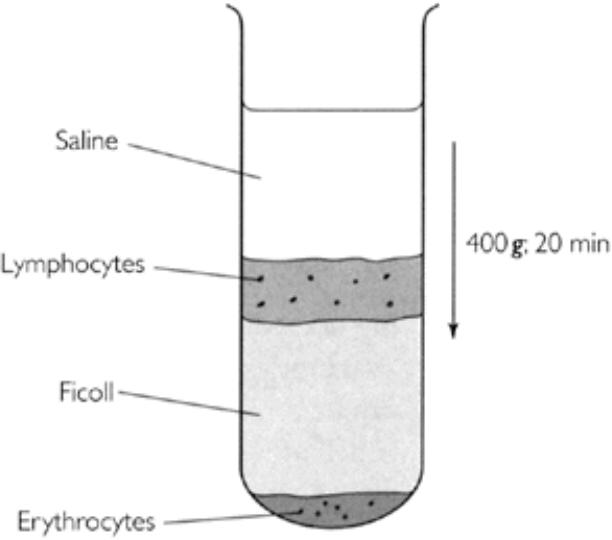

In [ ]:
import base64
import io
from IPython.display import display, HTML
import PIL.Image
import numpy as np
import faiss

# Function to encode user query
def encode_query(query, model):
    return model.embed_content(model=text_embedding_model, content=query)['embedding']

# Function to retrieve the most relevant embedding index
def retrieve_relevant_embedding_index(index, query_embedding):
    # Convert query embedding to numpy array and reshape
    query_embedding_np = np.array([query_embedding], dtype=np.float32)

    # Use FAISS search method directly
    distances, indices = index.search(query_embedding_np, k=1)
    return indices[0][0] if indices[0].size > 0 else None

# Function to get the relevant text and image
def get_relevant_text_and_image(text_index, image_index, texts, images):
    relevant_text = texts[text_index] if text_index is not None and text_index < len(texts) else None
    relevant_image = images[image_index] if image_index is not None and image_index < len(images) else None
    return relevant_text, relevant_image

# Example user query
user_query =  "How to Separate cells by using gradient centrifugation?"
query_embedding = encode_query(user_query, genai)

# Retrieve the most relevant text and image embeddings
text_index = retrieve_relevant_embedding_index(loaded_text_index, query_embedding) if loaded_text_index else None
image_index = retrieve_relevant_embedding_index(loaded_image_index, query_embedding) if loaded_image_index else None

# Extract relevant text and image
relevant_text, relevant_image = get_relevant_text_and_image(text_index, image_index, texts_to_embed, images_to_embed)

# Prepare the prompt for the LLM
texts_to_llm = [relevant_text['text']] if relevant_text else []
image_summaries_to_llm = [relevant_image['text']] if relevant_image else []
base64_images_to_user_query = [relevant_image['base64_image']] if relevant_image else []

llm_prompt = f"""
Here are some relevant passages I found about {user_query}:

{texts_to_llm}

Additionally, these are image summaries found related to the same query:

{image_summaries_to_llm}

Based on the information above, can you provide a short and crisp response to the query?
"""

# Generate content using the model
response_to_user = gemini_model.generate_content([llm_prompt])

# Prepare HTML for displaying images
images_html = ""
for image_base64 in base64_images_to_user_query:
    image_data = base64.b64decode(image_base64)
    image = PIL.Image.open(io.BytesIO(image_data))
    image_url = io.BytesIO()
    image.save(image_url, format='PNG')
    image_url.seek(0)
    image_html = f'<img src="data:image/png;base64,{base64.b64encode(image_url.getvalue()).decode()}" width="300"/>'
    images_html += image_html

# Display results
print("Query: " + user_query)
print("Answer: " + response_to_user.text)
display(HTML(images_html))
